# Evaluating LLMs with labeled data

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kluster-ai/klusterai-cookbook/blob/main/examples/model-comparison.ipynb)

In this hands-on tutorial, you'll learn how to systematically evaluate Language Models (LLMs) using the <a href="https://kluster.ai/" target="_blank">kluster.ai</a> batch API. We'll walk through a practical example of comparing different models for a real-world task.

Choosing the right LLM for your specific use case is crucial but can be challenging. While larger models might offer better performance, they often come with higher costs. kluster.ai provides high-performing models at competitive prices, making advanced AI more accessible.

Together, we'll create a systematic evaluation pipeline that:

1. Loads and processes a public dataset (which you can later replace with your own)
2. Tests three state-of-the-art Llama models on a text classification task
3. Compares their accuracy using annotated data
4. Helps you make an informed decision based on both performance and cost

Let's get started with understanding how we'll measure model performance.

## Understanding accuracy in model evaluation

Before comparing models, let's understand our main evaluation metric: accuracy. In machine learning, accuracy is one of the most intuitive performance metrics.

Accuracy is calculated by taking the number of correct predictions and dividing it by the total number of predictions. For example, if a model correctly classifies 85 out of 100 movie genres, its accuracy would be 85%.

$$ \text{Accuracy} = \frac{\text{Number of Correct Classifications}}{\text{Total Number of Classifications}} $$

We're choosing accuracy for this tutorial because:

1. It's easy to understand and interpret
2. It directly answers the question: "How often is our model correct?"

In the next section, we'll see how to implement this metric in our evaluation pipeline.

## Prerequisites

Before getting started, ensure you have the following:

- **A kluster.ai account** - sign up on the <a href="https://platform.kluster.ai/signup" target="_blank">kluster.ai platform</a> if you don't have one
- **A kluster.ai API key** - after signing in, go to the <a href="https://platform.kluster.ai/apikeys" target="_blank">**API Keys**</a> section and create a new key. For detailed instructions, check out the <a href="https://docs.kluster.ai/get-started/get-api-key/" target="_blank">Get an API key</a> guide

## Setup

In this notebook, we'll use Python's `getpass` module to safely input the key. Provide your unique kluster.ai API key (ensure there are no spaces).

In [1]:
from getpass import getpass
# Enter you personal kluster.ai API key (make sure in advance it has no blank spaces)
api_key = getpass("Enter your kluster.ai API key: ")

Enter your kluster.ai API key:  ········


In [2]:
%pip install -q OpenAI

Note: you may need to restart the kernel to use updated packages.


In [3]:
import urllib.request
import pandas as pd
import numpy as np
from openai import OpenAI
import time
import json
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 1000, 'display.width', 1000, 'display.max_rows',1000, 'display.max_colwidth', 500)

In [4]:
# Set up the client
client = OpenAI(
    base_url="https://api.kluster.ai/v1",
    api_key=api_key,
)

## Build our evaluation pipeline

In this section, we'll create several utility functions that will help us:

1. Prepare our data for batch processing
2. Send requests to the kluster.ai API
3. Monitor the progress of our evaluation
4. Collect and analyze results

These functions will make our evaluation process more efficient and organized. Let's go through each one and understand its purpose:

1. **`create_tasks()`** - formats our data for the API
2. **`save_tasks()`** - prepares batch files for processing
3. **`monitor_job_status()`** - tracks evaluation progress
4. **`get_results()`** - collects and processes model outputs

### Create and manage batch files

A batch file in our context is a collection of requests that we'll send to our models for evaluation. Think of it as a organized list of tasks we want our models to complete.

We'll take the following steps to create batch files:

1. **Creating tasks** - we'll convert each movie description into a format LLMs can process
2. **Organizing data** -we'll add necessary metadata and instructions for each task
3. **Saving files** - we'll store these tasks in a structured format (JSONL) for processing

Let's break down the key components of our batch file creation:
- **`custom_id`** - helps us track individual requests
- **`system_prompt`** - provides instructions to the model
- **`content`** - the actual text we want to classify

This structured approach allows us to efficiently process multiple requests in parallel.

In [5]:
def create_tasks(df, task_type, system_prompt, model):
    tasks = []
    for index, row in df.iterrows():
        content = row['Overview']
        
        task = {
            "custom_id": f"{task_type}-{index}",
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                "model": model,
                "temperature": 0,
                "messages": [
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": content},
                ],
            }
        }
        tasks.append(task)
    return tasks

def save_tasks(tasks, task_type):
    filename = f"batch_tasks_{task_type}.jsonl"
    with open(filename, 'w') as file:
        for task in tasks:
            file.write(json.dumps(task) + '\n')
    return filename

### Upload files to kluster.ai

Now that we've prepared our batch files, we'll upload them to the <a href="https://platform.kluster.ai/" target="_blank">kluster.ai platform</a> for batch inference. This step is crucial for:

1. Getting our data to the models
2. Setting up the processing queue
3. Preparing for inference

Once the upload is complete, the following actions will take place:

1. The platform queues our requests
2. Models process them efficiently
3. Results are made available for collection

In [6]:
def create_batch_job(file_name):
    print(f"Creating batch job for {file_name}")
    batch_file = client.files.create(
        file=open(file_name, "rb"),
        purpose="batch"
    )

    batch_job = client.batches.create(
        input_file_id=batch_file.id,
        endpoint="/v1/chat/completions",
        completion_window="24h"
    )

    return batch_job

### Check job progress

This function provides real-time monitoring of batch job progress:

- Continuously checks job status via the kluster.ai API
- Displays current completion count (completed/total requests)
- Updates status every 10 seconds until job is finished
- Automatically clears previous output for clean progress tracking

In [7]:
def parse_json_objects(data_string):
    if isinstance(data_string, bytes):
        data_string = data_string.decode('utf-8')

    json_strings = data_string.strip().split('\n')
    json_objects = []

    for json_str in json_strings:
        try:
            json_obj = json.loads(json_str)
            json_objects.append(json_obj)
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")

    return json_objects

def monitor_job_status(client, job_id, task_type):
    all_completed = False

    while not all_completed:
        all_completed = True
        output_lines = []

        updated_job = client.batches.retrieve(job_id)

        if updated_job.status.lower() != "completed":
            all_completed = False
            completed = updated_job.request_counts.completed
            total = updated_job.request_counts.total
            output_lines.append(f"{task_type.capitalize()} job status: {updated_job.status} - Progress: {completed}/{total}")
        else:
            output_lines.append(f"{task_type.capitalize()} job completed!")

        # Clear the output and display updated status
        clear_output(wait=True)
        for line in output_lines:
            display(line)

        if not all_completed:
            time.sleep(10)

### Collect and process results

The `get_results()` function below does the following:

1. Retrieves the completed batch job results
2. Extracts the model's response content from each result
3. Returns a list of all model responses



In [8]:
def get_results(client, job_id):
    batch_job = client.batches.retrieve(job_id)
    result_file_id = batch_job.output_file_id
    result = client.files.content(result_file_id).content
    results = parse_json_objects(result)
    answers = []
    
    for res in results:
        result = res['response']['body']['choices'][0]['message']['content']
        answers.append(result)
    
    return answers

## Prepare a real dataset for batch inference

Now that we have covered the core general functions and workflow used for batch inference, in this guide, we'll use the IMDb Top 1000 dataset. This dataset contains information about top-rated movies, including their descriptions and genres. Let's download it and see what it looks like.

In [9]:
# IMDB Top 1000 dataset:
url = "https://raw.githubusercontent.com/kluster-ai/klusterai-cookbook/refs/heads/main/data/imdb_top_1000.csv"
urllib.request.urlretrieve(url,filename='imdb_top_1000.csv')

# Load and process the dataset based on URL content
df = pd.read_csv('imdb_top_1000.csv', usecols=['Series_Title', 'Overview', 'Genre'])
df.head(3)

,Series_Title,Genre,Overview
0,The Shawshank Redemption,Drama,"Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency."
1,The Godfather,"Crime, Drama",An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his reluctant son.
2,The Dark Knight,"Action, Crime, Drama","When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice."


As you may notice, each movie already has an annotated label, and in some cases, there may be more than one label for each movie. We will ask the LLM to identify just one genre for this notebook. We will consider the prediction correct if the predicted genre matches at least one of the genres listed in the dataset’s genre column (our ground truth). Using ground truth annotated data, we can calculate the accuracy and measure how well the LLM performed.

## Perform batch inference

With LLMs, it is really important to write a good prompt, including the system prompt. Below, you can see our example instructions for the LLM. You should experiment with this and see how it changes performance!

In [10]:
SYSTEM_PROMPT = '''
    You are a helpful assitant that classifies movie genres based on the movie description. Choose one of the following options: 
    Action, Adventure, Animation, Biography, Comedy, Crime, Drama, Family, Fantasy, Film-Noir, History, Horror, Music, Musical, Mystery, Romance, Sci-Fi, Sport, Thriller, War, Western.
    Provide your response as a single word with the matching genre. Don't include punctuation.
    '''

Now that the prompt is defined, it’s time to execute the code and run the classification task for each model. In this step, we loop through the list of models, creating the requests and batch jobs, monitoring progress, and retrieving the results.

In [11]:
# Define models
models = {
        '8B':"klusterai/Meta-Llama-3.1-8B-Instruct-Turbo",
        '70B':"klusterai/Meta-Llama-3.3-70B-Instruct-Turbo",
        '405B':"klusterai/Meta-Llama-3.1-405B-Instruct-Turbo",
        }

# Process each model: create tasks, run jobs, and get results
for name, model in models.items():
    task_list = create_tasks(df, task_type='assistant', system_prompt=SYSTEM_PROMPT, model=model)
    filename = save_tasks(task_list, task_type='assistant')
    job = create_batch_job(filename)
    monitor_job_status(client=client, job_id=job.id, task_type=f'{name} model')
    df[f'{name}_genre'] = get_results(client=client, job_id=job.id)

'405b model job completed!'

## Analyze the results

Now that we've evaluated our models let's analyze their performance. The graph below shows the accuracy scores for each model we tested. Here's what we can observe:

1. Performance comparison
   - The 70B and 405B models achieved similar accuracy levels
   - Both outperformed the 8B model significantly
2. Cost-benefit analysis
   - Given the similar performance of the 70B and 405B models
   - Considering the lower cost of the 70B model
   - The 70B model emerges as the most cost-effective choice

We recommend using the 70B model for this specific task based on our evaluation. It offers strong performance comparable to the larger model, better cost efficiency, and a good balance of accuracy and resource usage.

This demonstrates how systematic evaluation can help make data-driven decisions in model selection.

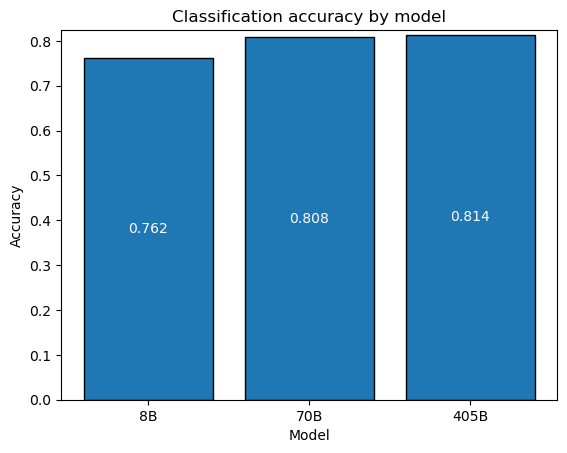

In [12]:
# Calculate accuracy for each model
accuracies = {}
for name, _ in models.items():
    accuracy = df.apply(lambda row: row[f'{name}_genre'] in row['Genre'].split(', '), axis=1).mean()
    accuracies[name] = accuracy

# Create the bar plot
fig, ax = plt.subplots()
bars = ax.bar(accuracies.keys(), accuracies.values(), edgecolor='black')
ax.bar_label(bars, label_type='center', color='white', fmt="%.3f")
ax.set_ylim(0, max(accuracies.values())+ 0.01)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')

ax.set_title('Classification accuracy by model')
plt.show()

## Conclusion

In this tutorial, we've covered the following key concepts:

- **Model evaluation process** - how to systematically compare LLM performance, using accuracy as a key metric and implementing batch inference for efficient evaluation
- **Cost-performance balance** - larger models aren’t always significantly better; the importance of considering cost-effectiveness and making data-driven model selections
- **Practical implementations** - using the kluster.ai batch API effectively, processing large datasets efficiently, and making informed decisions based on results

With this knowledge, you are now equipped to:

- **Apply to your use case** - adapt this approach to your specific needs, use your own labeled datasets, and customize evaluation metrics as needed
- **Optimize further** - experiment with different prompts, try other model configurations and explore additional evaluation metrics
- **Scale your solution** - implement in production environments, monitor performance over time, and adjust based on real-world feedback

Remember: The goal is finding the right balance between your application's performance and cost.